In [1]:
# Example-2-GP-BS-Derivatives
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

# Overview
The purpose of this notebook is to demonstrate the derivation of the greeks in a Gaussian Process Regression model (GP), fitted to option price data. 

In this notebook, European option prices are generated from the Black-Scholes model.  The notebook begins by building a GP call model, where the input is the underlying price. The delta is then derived and compared with the Black-Scholes (BS)
delta. The exercise is repeated, but using the volatility as the input instead of the underlying price. The vega of the GP is then derived and compared with the BS vega.

In [2]:
from BlackScholes import bsformula

import numpy as np
import scipy as sp

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt

%matplotlib inline

## Black-Scholes Model

First, set the model parameters

In [3]:
KC = 130    # Call strike
KP = 70     # Put strike
r = 0.002   # risk-free rate
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity
S0 = 100    # Underlying spot

In [4]:
lb = 0   # lower bound on domain
ub = 300 # upper bound on domain
training_number = 100 # Number of training samples
testing_number = 50   # Number of testing samples
sigma_n = 1e-8 # additive noise in GP

Define the call and put prices using the BS model

In [5]:
call = lambda x, y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[0]
put = lambda x, y: bsformula(-1, lb+(ub-lb)*x, KP, r, T, y, 0)[0]

# Delta

Generate the training and testing data, where the input is the gridded underlying and the output are the option prices. 

In [6]:
x_train = np.array(np.linspace(0.01, 1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01, 1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

Fit the GP model to the generated data

In [7]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train, y_train)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=20,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

Get the model's predicted outputs for each of the test inputs

In [8]:
y_pred, sigma_hat = gp.predict(x_test, return_std=True)

/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Derive the GP delta

In [9]:
l = gp.kernel_.length_scale
rbf = gaussian_process.kernels.RBF(length_scale=l)
 
Kernel = rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime = np.dot(k_s_prime, alpha_p) / (ub - lb)

Calculate the BS delta

In [10]:
delta = lambda x, y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[1]
delta(x_test, sigma) - f_prime

array([[ 4.84307695e-04],
       [-1.08918626e-04],
       [-2.91618222e-05],
       [ 8.60350357e-05],
       [ 3.33168011e-05],
       [-2.53176930e-05],
       [-5.07483131e-05],
       [ 7.07825164e-06],
       [ 1.39213664e-05],
       [-1.35130371e-05],
       [-5.09156375e-05],
       [ 7.00502338e-06],
       [-5.69830264e-05],
       [-2.48890968e-05],
       [-2.27851960e-05],
       [-3.58832294e-05],
       [-4.21880553e-05],
       [-3.81434240e-05],
       [-2.69698078e-05],
       [-2.08925095e-05],
       [-2.63691760e-05],
       [-3.85055712e-05],
       [-4.62312952e-05],
       [-4.31809098e-05],
       [-3.74999561e-05],
       [-3.35809201e-05],
       [-4.25953832e-05],
       [-5.87952160e-05],
       [-6.91413138e-05],
       [-6.50452308e-05],
       [-5.04262611e-05],
       [-4.29148413e-05],
       [-5.52078005e-05],
       [-8.36374458e-05],
       [-1.12426887e-04],
       [-1.21165347e-04],
       [-1.10638665e-04],
       [-9.92387082e-05],
       [-1.1

Compare the GP delta with the BS delta

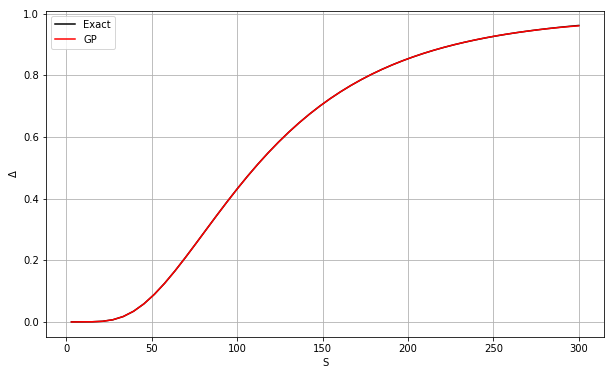

In [11]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10});

Show the error between the GP delta and the BS delta

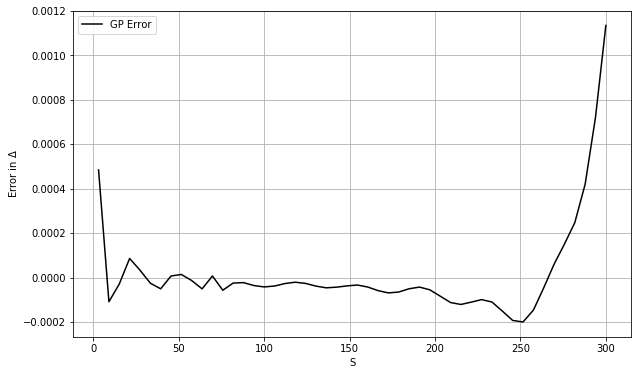

In [12]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma) - f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('Error in $\Delta$')
plt.legend(loc = 'best', prop={'size':10});

## Vega

Generate the training and testing data, where the input is the gridded underlying and the output are the option prices. The inputs are again scaled to the unit domain. 

In [13]:
x_train = np.array(np.linspace(0.01, 1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01, 1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train[idx]))
y_train = np.array(y_train)

Fit the GP model to the generated data

In [14]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train, y_train)

/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=20,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

Get the model's predicted outputs for each of the test inputs

In [15]:
y_pred, sigma_hat = gp.predict(x_test, return_std=True)

/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Derive the GP delta

In [16]:
l = gp.kernel_.length_scale
rbf = gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i, j] = (1.0/l**2) * (x_train[j] - x_test[i]) * k_s[i, j]
        
f_prime = np.dot(k_s_prime, alpha_p)

Calculate the BS delta

In [17]:
vega = lambda x, y: bsformula(1, lb + (ub-lb) * x, KC, r, T, y, 0)[2]
vega((S0-lb)/(ub-lb), x_test) - f_prime

array([[ 0.00362847],
       [-0.0153968 ],
       [ 0.04528361],
       [-0.0729166 ],
       [ 0.00591578],
       [-0.06241966],
       [-0.01553885],
       [-0.00368244],
       [ 0.03085346],
       [ 0.0072137 ],
       [ 0.00825525],
       [ 0.01521479],
       [ 0.02292174],
       [ 0.0205735 ],
       [ 0.00761565],
       [ 0.01139819],
       [ 0.00536583],
       [-0.00624957],
       [-0.00532925],
       [-0.00071578],
       [-0.01114235],
       [-0.00902163],
       [-0.00705329],
       [-0.00521181],
       [-0.00483365],
       [-0.0025368 ],
       [-0.00317089],
       [-0.00497722],
       [-0.0028917 ],
       [-0.00577849],
       [-0.00702065],
       [-0.00618553],
       [-0.00974994],
       [-0.00635076],
       [-0.00499353],
       [-0.00586261],
       [-0.00513673],
       [-0.0025747 ],
       [-0.00527992],
       [-0.00624049],
       [-0.01140437],
       [-0.01252832],
       [-0.00989304],
       [-0.01459673],
       [-0.02190291],
       [-0

Compare the GP vega with the BS vega


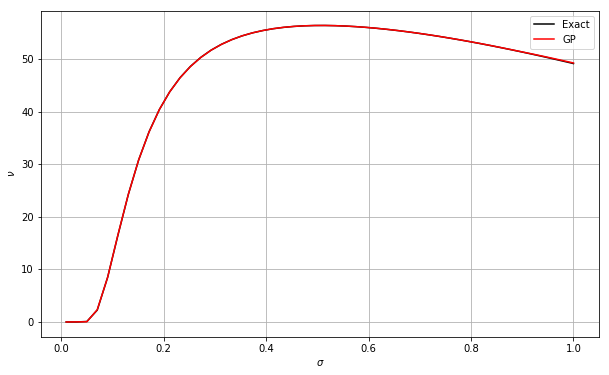

In [18]:
plt.figure(figsize = (10,6), facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test), color = 'black', label = 'Exact')
plt.plot(x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('$\\nu$')
plt.legend(loc = 'best', prop={'size':10});

Plot the error between the GP vega and the BS vega


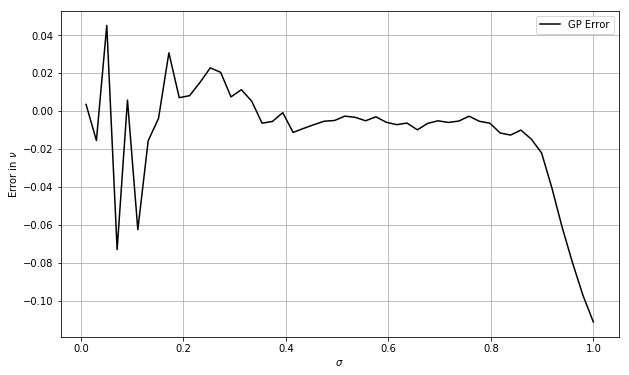

In [20]:
plt.figure(figsize = (10,6), facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test)-f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('Error in $\\nu$')
plt.legend(loc = 'best', prop={'size':10});